In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import umap

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#  XGBoost
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

In [2]:
df=pd.read_csv('mutual_funds.csv')
df.head()

,Scheme Name,Category,Min Investment (₹),Risk Level,1Y Returns (%),3Y Returns (%),5Y Returns (%),Expense Ratio (%),AUM (Cr),Investment Type,Scheme Type,ISIN,SIP Available
0,Invesco India-Invesco GCT Fund of Fund-Dir (G),FoFs Overseas,1000,Very High,42.55,8.28,NaN,0.60,335.69,Growth,Active Fund,INF205KA1270,Yes
1,LIC MF Gold ETF Fund of Fund - Direct (G),FoFs Domestic,5000,High,39.97,19.69,15.31,0.20,80.36,Growth,Active Fund,INF397L01BU4,Yes
2,UTI-Gold ETF Fund of Fund - Direct (G),FoFs Domestic,5000,High,39.28,NaN,NaN,0.19,171.93,Growth,Active Fund,INF789F1AWB9,Yes
3,UTI-Silver ETF Fund of Fund - Direct (G),FoFs Domestic,5000,Very High,39.22,NaN,NaN,0.15,43.59,Growth,Active Fund,INF789F1AYL4,Yes
4,ICICI Pru Silver ETF Fund of Fund - Dir (G),FoFs Domestic,100,Very High,39.15,13.64,NaN,0.12,1008.48,Growth,Active Fund,INF109KC1Y98,Yes


In [3]:
df.isnull().sum()

Scheme Name             0
Category                0
Min Investment (₹)      0
Risk Level              0
1Y Returns (%)          0
3Y Returns (%)        272
5Y Returns (%)        432
Expense Ratio (%)       0
AUM (Cr)                0
Investment Type         0
Scheme Type             0
ISIN                    0
SIP Available           0
dtype: int64

In [4]:
df.duplicated().sum()

0

In [5]:
# Fill missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

In [6]:
df.isnull().sum()

Scheme Name           0
Category              0
Min Investment (₹)    0
Risk Level            0
1Y Returns (%)        0
3Y Returns (%)        0
5Y Returns (%)        0
Expense Ratio (%)     0
AUM (Cr)              0
Investment Type       0
Scheme Type           0
ISIN                  0
SIP Available         0
dtype: int64

In [7]:
df.size

15600

In [8]:
df.shape

(1200, 13)

In [9]:
df_grouped = df.groupby("Risk Level")["AUM (Cr)"].mean()
print(df_grouped)

Risk Level
High               3315.801795
Low                5182.622308
Moderate           4675.007685
Moderately High    1653.116164
Moderately Low     5096.282847
Very High          5261.258060
Name: AUM (Cr), dtype: float64


In [10]:
df_pivot = df.pivot_table(values="AUM (Cr)", index="Risk Level", columns="Expense Ratio (%)", aggfunc="mean")
print(df_pivot)

Expense Ratio (%)    0.03         0.05         0.06         0.07         0.08  \
Risk Level                                                                      
High               161.32          NaN  1752.155000          NaN          NaN   
Low                   NaN  3241.633333  3472.105000  4503.647500  2827.508889   
Moderate              NaN          NaN  4602.292500          NaN   213.445000   
Moderately High       NaN          NaN          NaN          NaN   552.760000   
Moderately Low        NaN          NaN  4178.660000  2060.020000  1035.515000   
Very High             NaN   154.103333  1186.063333   982.763333          NaN   

Expense Ratio (%)       0.09          0.10    0.11        0.12     0.13  ...  \
Risk Level                                                               ...   
High                1575.680    113.720000     NaN         NaN      NaN  ...   
Low                  419.435   4780.320000  246.80         NaN    97.63  ...   
Moderate           10230.695  2

In [11]:
df_crosstab = pd.crosstab(df["Risk Level"], df["Expense Ratio (%)"])
print(df_crosstab)

Expense Ratio (%)  0.03  0.05  0.06  0.07  0.08  0.09  0.10  0.11  0.12  0.13  \
Risk Level                                                                      
High                  1     0     2     0     0     1     1     0     0     0   
Low                   0     3     4     4     9     2     5     2     0     2   
Moderate              0     0     4     0     2     2     1     1     1     1   
Moderately High       0     0     0     0     1     0     2     0     0     1   
Moderately Low        0     0     1     3     2     2     6     0     4     2   
Very High             0     3     3     3     0     2     7     1     4     1   

Expense Ratio (%)  ...  1.70  1.78  1.80  1.83  1.89  2.00  2.07  2.13  2.45  \
Risk Level         ...                                                         
High               ...     0     0     0     0     0     0     0     0     0   
Low                ...     0     0     0     0     0     0     0     0     0   
Moderate           ...     0   

# Boxplots for Outlier Visualization

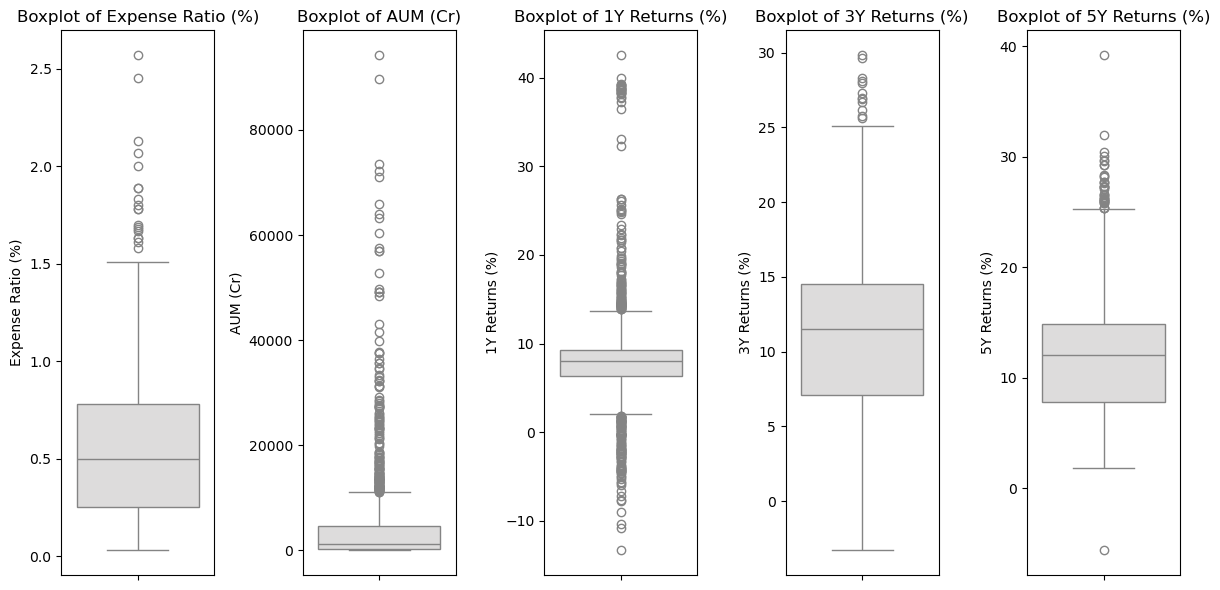

In [13]:
# Select numerical columns
numeric_cols = ["Expense Ratio (%)", "AUM (Cr)", "1Y Returns (%)", "3Y Returns (%)", "5Y Returns (%)"]# Modify as per dataset

# Boxplots BEFORE outlier removal
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.boxplot(y=df[col], palette="coolwarm")
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


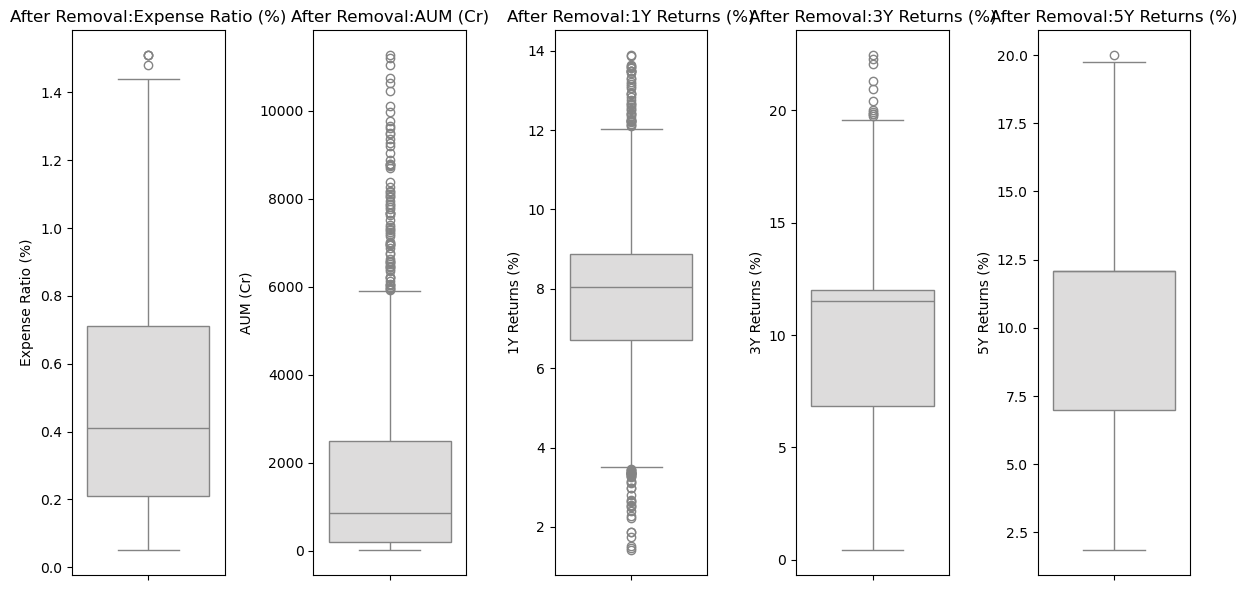

In [14]:
# Select numerical columns
features = ["Expense Ratio (%)", "AUM (Cr)", "1Y Returns (%)", "3Y Returns (%)", "5Y Returns (%)"]# Modify as per dataset

# Function to detect and remove outliers using IQR
def remove_outliers_iqr(df, features):
    df_clean = df.copy()
    for col in features:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean
# Remove outliers
df_clean = remove_outliers_iqr(df, numeric_cols)

# Boxplots AFTER outlier removal
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.boxplot(y=df_clean[col], palette="coolwarm")
    plt.title(f'After Removal:{col}')
plt.tight_layout()
plt.show()


# Exploratory Data Analysis

# Risk Level Distribution

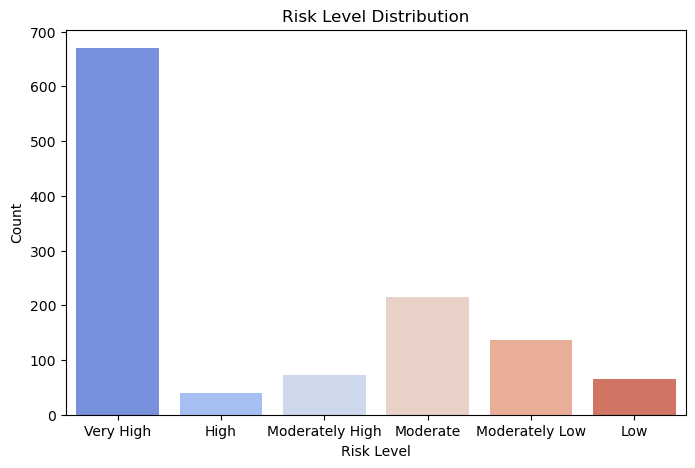

In [17]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Risk Level"], palette="coolwarm")
plt.title("Risk Level Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.show()

# Correlation Heatmap

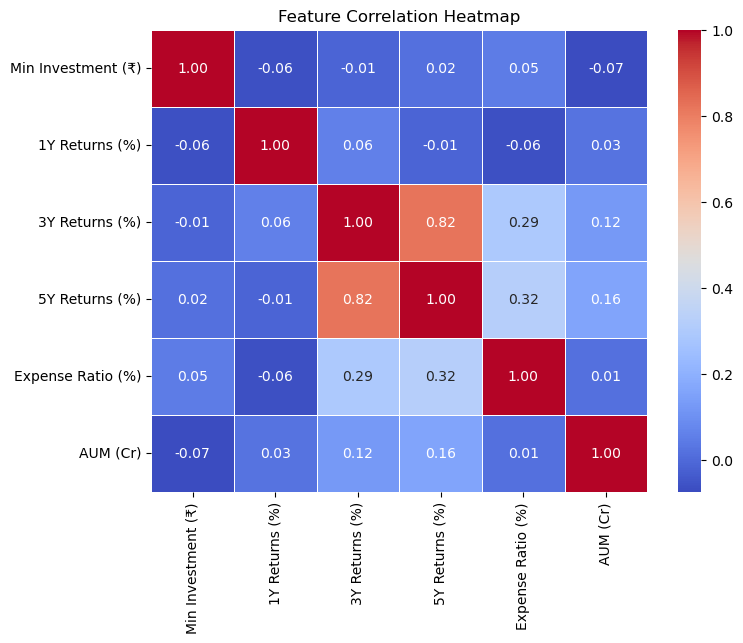

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# All Numeric Feature Distributions

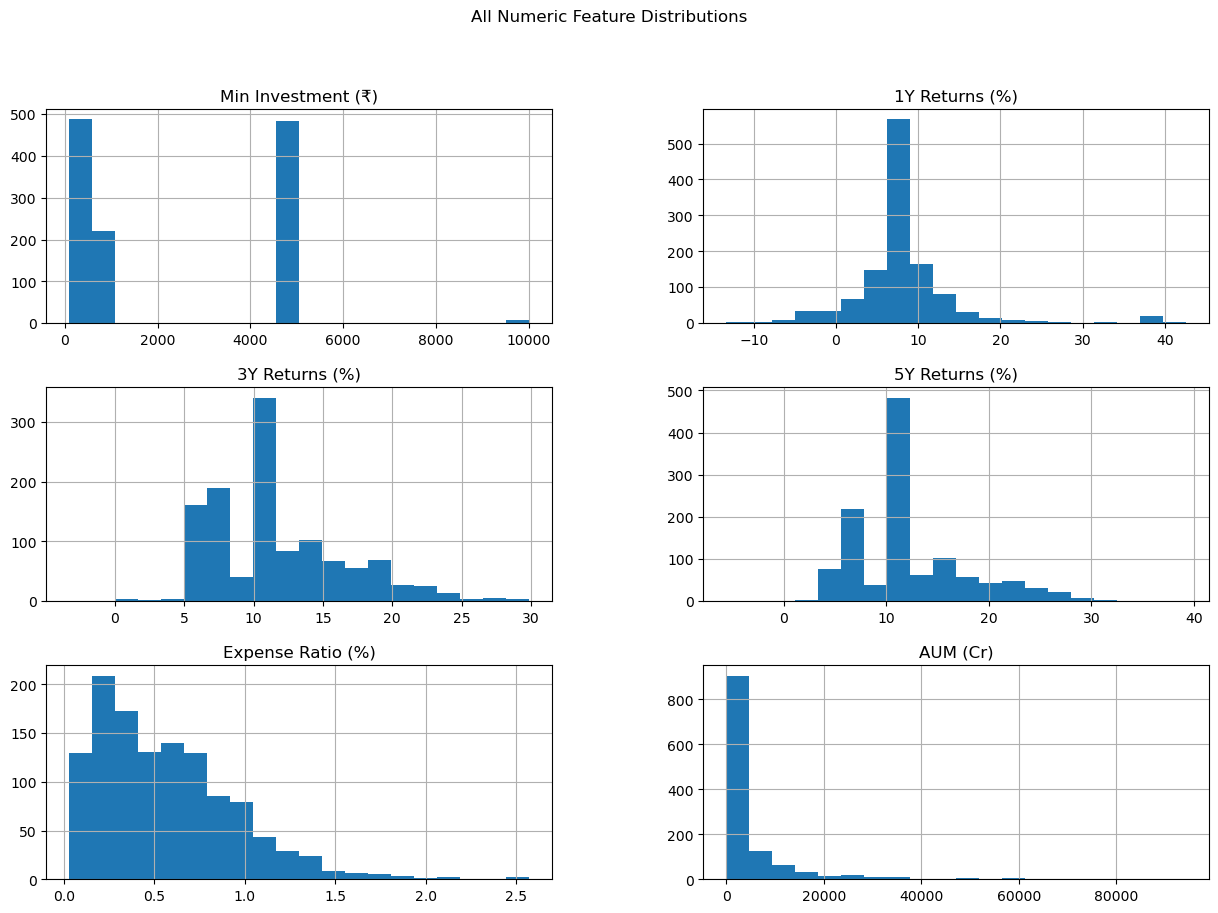

In [21]:
# Automatically select numeric columns
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns

# Plot all numeric features
df[numeric_features].hist(bins=20, figsize=(15,10))
plt.suptitle('All Numeric Feature Distributions')
plt.show()


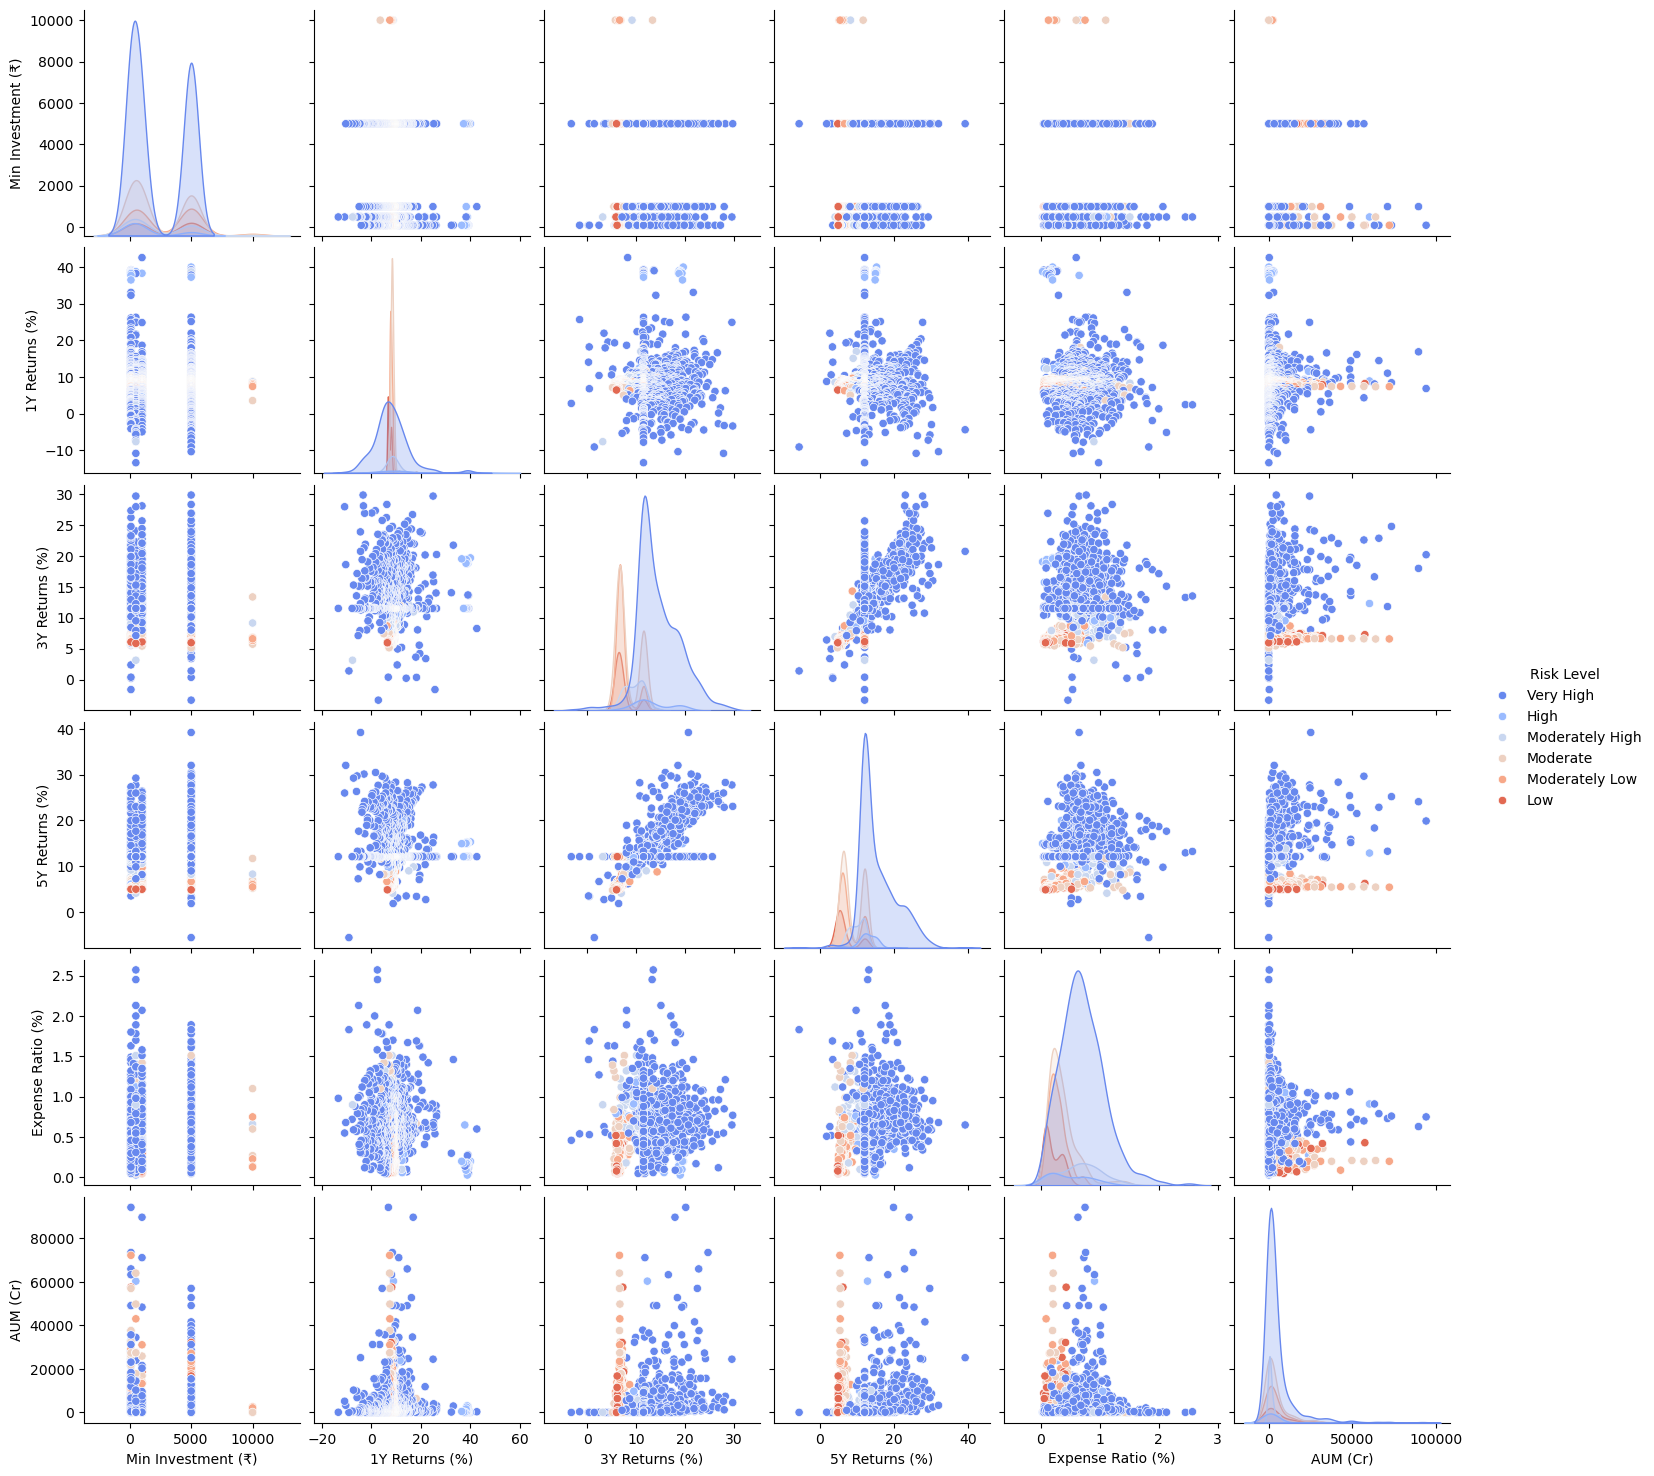

In [22]:
# Pairplot
sns.pairplot(df, hue="Risk Level", palette="coolwarm")
plt.show()

In [23]:
# Encode Risk Level
risk_mapping = {
    'Low': 1,
    'Moderately Low': 2,
    'Moderate': 3,
    'Moderately High': 4,
    'High': 5,
    'Very High': 6
}
df['Risk_Level_Encoded'] = df['Risk Level'].map(risk_mapping)
df = df.dropna(subset=['Risk_Level_Encoded'])

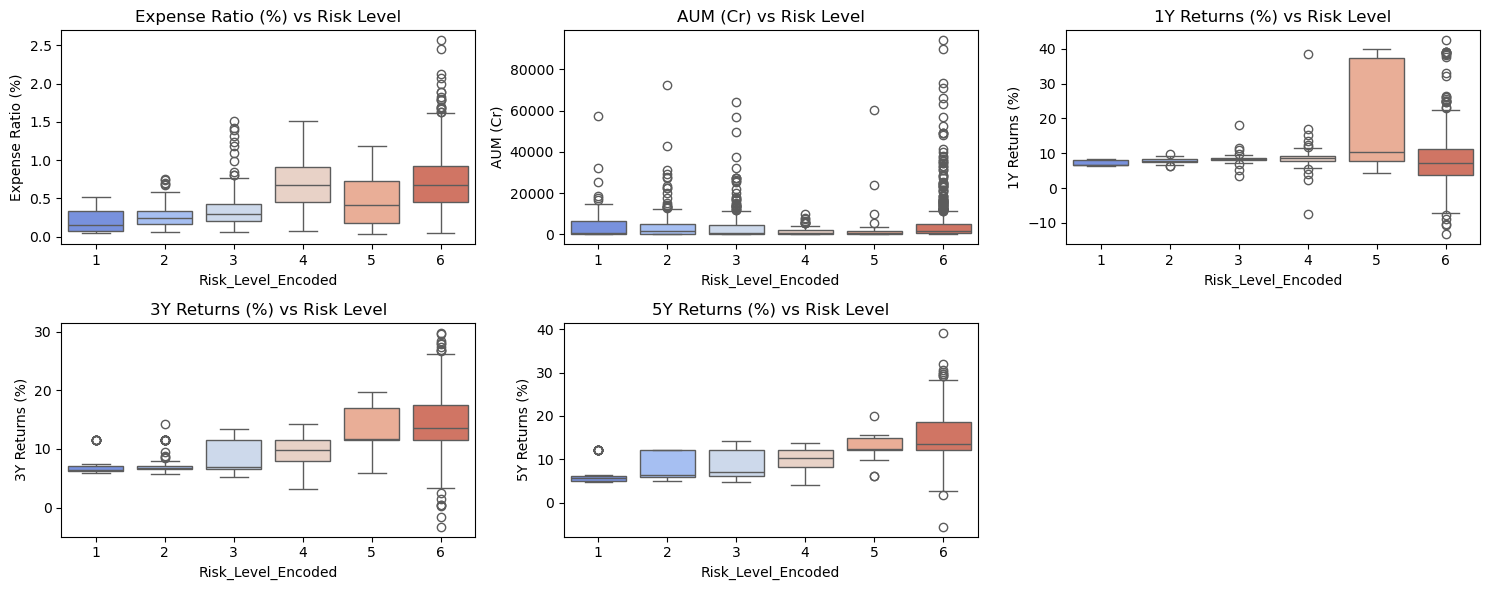

In [24]:
# Boxplots for key features by Risk Level
plt.figure(figsize=(15, 6))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df["Risk_Level_Encoded"], y=df[col], palette="coolwarm")
    plt.title(f"{col} vs Risk Level")
plt.tight_layout()
plt.show()

In [25]:
#  Feature selection
numeric_cols = ['1Y Returns (%)', '3Y Returns (%)', '5Y Returns (%)',
                'Expense Ratio (%)', 'AUM (Cr)', 'Min Investment (₹)']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=numeric_cols)

X = df[numeric_cols]
y = df['Risk_Level_Encoded'] - 1  # Shift to 0-based indexing

In [26]:
#  Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
#  Balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [28]:
#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [29]:
#  PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

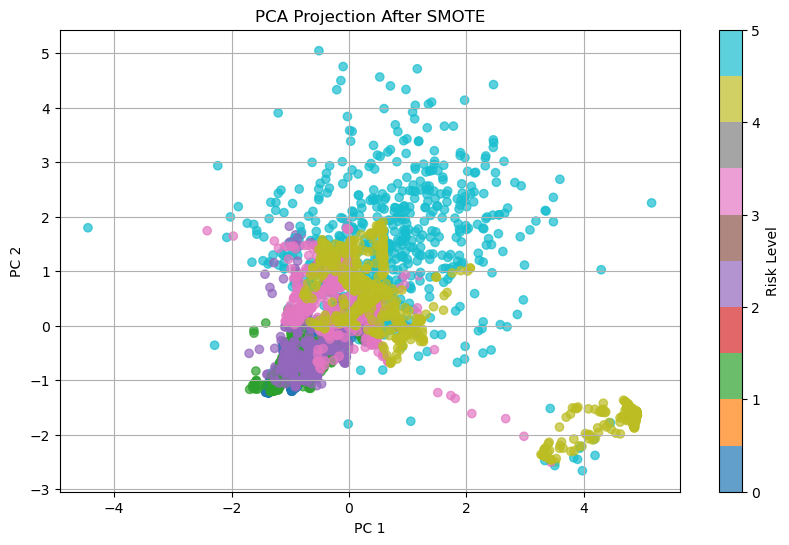

In [30]:
#  PCA Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Risk Level')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Projection After SMOTE')
plt.grid(True)
plt.show()

In [31]:
#  Models and their grids
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    "Decision Tree": {
        'max_depth': [None, 5, 10, 15],
        'criterion': ['gini', 'entropy']
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'max_features': ['auto', 'sqrt']
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}


In [32]:
# Add models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

In [33]:
#  XGBoost
if xgb_available:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    param_grids["XGBoost"] = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.1, 0.3]
    }

In [34]:
# Training with GridSearchCV
results = {}

for name in models:
    print(f"\n Tuning {name}...")
    model = models[name]
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    print(f" Best Parameters for {name}: {grid.best_params_}")
    
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"{name} Accuracy: {acc:.2f}")
    print(classification_report(y_test, y_pred))



 Tuning Logistic Regression...
 Best Parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
Logistic Regression Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.61      0.66      0.63       134
           1       0.45      0.36      0.40       134
           2       0.40      0.39      0.39       134
           3       0.59      0.66      0.62       134
           4       0.59      0.65      0.62       134
           5       0.72      0.66      0.69       134

    accuracy                           0.56       804
   macro avg       0.56      0.56      0.56       804
weighted avg       0.56      0.56      0.56       804


 Tuning KNN...
 Best Parameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}
KNN Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       134
           1       0.87      0.87      0.87       134
           2       0.86      0.84      0.85       134

# Comparison Plot 

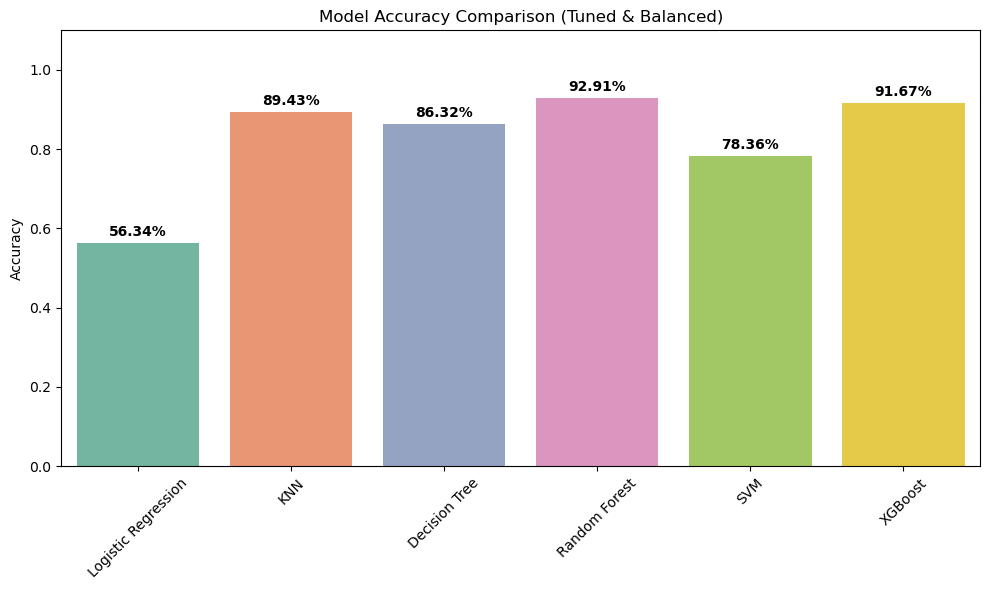

In [35]:
#  Comparison Plot with % Accuracy Labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(results.keys()), y=list(results.values()), palette="Set2")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (Tuned & Balanced)")
plt.xticks(rotation=45)

# Add percentage text labels on top of bars
for i, acc in enumerate(results.values()):
    ax.text(i, acc + 0.01, f"{acc * 100:.2f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, 1.1)  # extend y-axis to make space for labels
plt.tight_layout()
plt.show()


# UMAP

Random Forest Accuracy: 0.9266169154228856


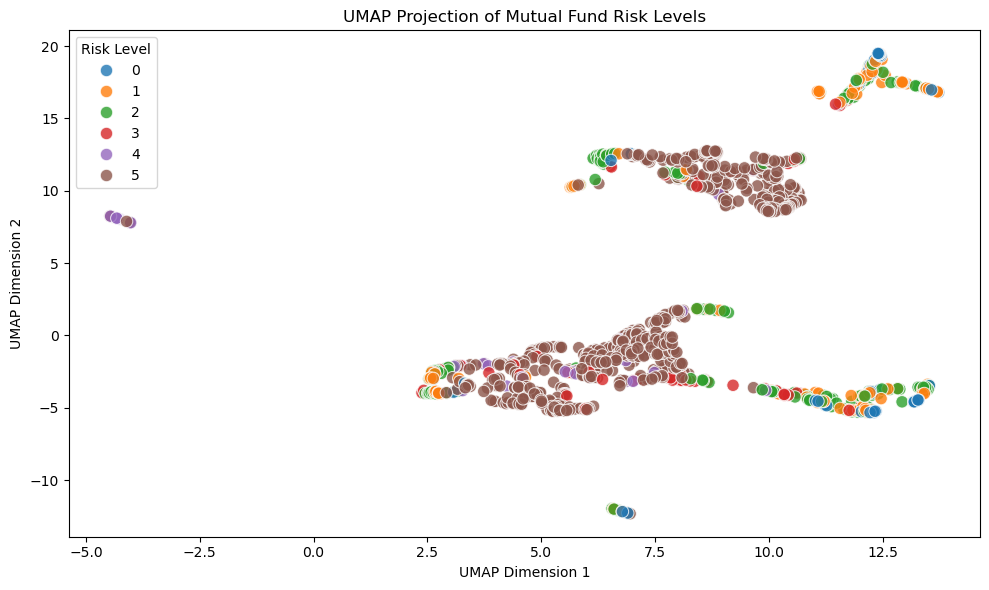

In [36]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))

# Apply UMAP for dimensionality reduction (2D)
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_2d.fit_transform(X_scaled)

#  Plot UMAP projection
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette="tab10", s=80, alpha=0.8)
plt.title("UMAP Projection of Mutual Fund Risk Levels")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Risk Level', loc='best')
plt.tight_layout()
plt.show()

#  Confusion Matrix

<Figure size 800x600 with 0 Axes>

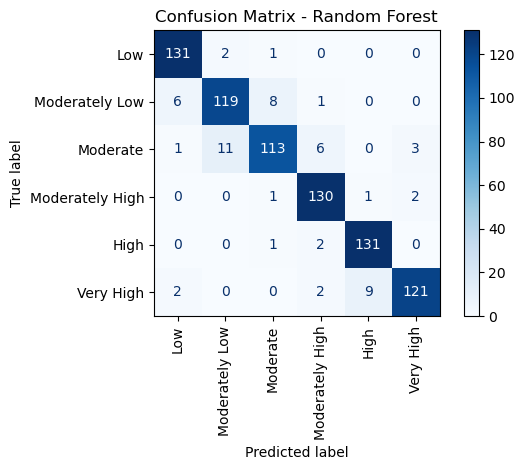

In [37]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=risk_mapping.keys())
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# ROC-AUC Curve - Random Forest

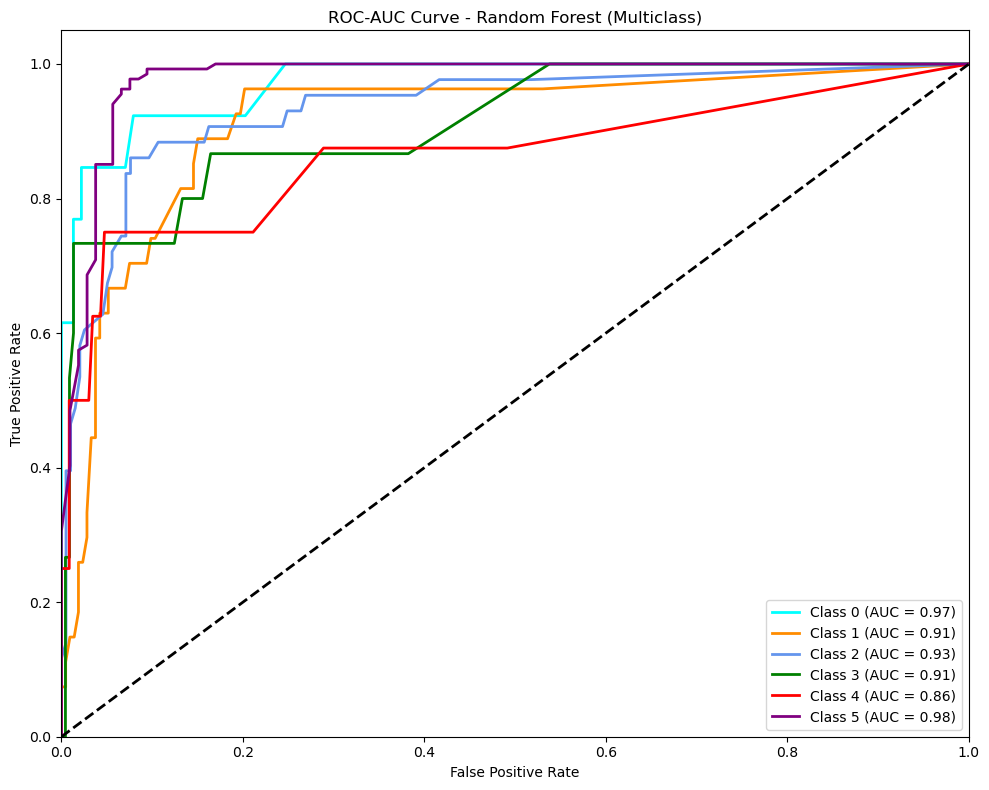

In [38]:
#  Binarize labels for multiclass AUC
y_bin = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])  # 6 classes
n_classes = y_bin.shape[1]

#  Split again for full pipeline
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_scaled, y_bin, test_size=0.2, random_state=42, stratify=y)

#  One-vs-Rest RF Classifier
rf_bin = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_bin.fit(X_train_bin, y_train_bin)
y_score = rf_bin.predict_proba(X_test_bin)

#  Plot ROC Curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

#  Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve - Random Forest (Multiclass)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
